In [1]:
# 모듈 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 회귀분석의 목적

|설명모형|예측모형|
|---|---|
|전통적인 통계분야로서 데이터가 적은 모형|데이터마이닝 분야로서 데이터가 충분한 모형|
| ${\hat y} = \beta_1 X + \beta_0 $ 에서 $X$ 에 초점을 둠|  ${\hat y} = \beta_1 X + \beta_0 $ 에서 $\hat y$ 에 초점을 둠|
|종속(타깃,출력)변수와 독립(피처,예측)변수들간의 관계를 **설명**|새로운 사례에 대해 출력값을 **예측**<br>적합된 모형을 이용하여 알려지지 않은 데이터에 대한 **예측**|
|모집단에서 가정하는 가설적 관계에 대한 정보를 <br> 최대한 반영할 수 있도록 전체 데이터 집합 사용하여 최상의 적합모형 추정|학습용 데이터세트(모형 추정)와 평가용 데이터세트(모형 성능평가)로 나눔|

---

## LinearRegression을 이용한 주택 가격 예측

### 데이터셋 : House Sales in King County, USA

- 2014년 5월 ~ 2015년 5월까지 King County 주택가격
- kc_house_data.csv
- 출처: https://www.kaggle.com/harlfoxem/housesalesprediction

### 데이터 준비

In [2]:
raw = pd.read_csv('data/kc_house_data.csv')
house = raw.copy()

In [5]:
print(f'데이터 크기: {house.shape}')
house.head(3)

데이터 크기: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


### 데이터 탐색 및 전처리

In [7]:
# 데이터의 type보기
house.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [8]:
house.dtypes.value_counts()

int64      15
float64     5
object      1
Name: count, dtype: int64

#### 데이터 전처리 함수

In [11]:
def data_preprocessing(df):
    df_new = df.copy()
    df_new['sold_year'] = df_new.date.str[:4].astype('int64')
    df_new['sold-built_year'] = df_new['sold_year'] - df_new['yr_built'] + 1
    df_new.drop(['id','date'],axis=1, inplace=True)
    return df_new

In [12]:
house_df = data_preprocessing(house)
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21613 non-null  float64
 1   bedrooms         21613 non-null  int64  
 2   bathrooms        21613 non-null  float64
 3   sqft_living      21613 non-null  int64  
 4   sqft_lot         21613 non-null  int64  
 5   floors           21613 non-null  float64
 6   waterfront       21613 non-null  int64  
 7   view             21613 non-null  int64  
 8   condition        21613 non-null  int64  
 9   grade            21613 non-null  int64  
 10  sqft_above       21613 non-null  int64  
 11  sqft_basement    21613 non-null  int64  
 12  yr_built         21613 non-null  int64  
 13  yr_renovated     21613 non-null  int64  
 14  zipcode          21613 non-null  int64  
 15  lat              21613 non-null  float64
 16  long             21613 non-null  float64
 17  sqft_living1

#### 변수별 히스토그램

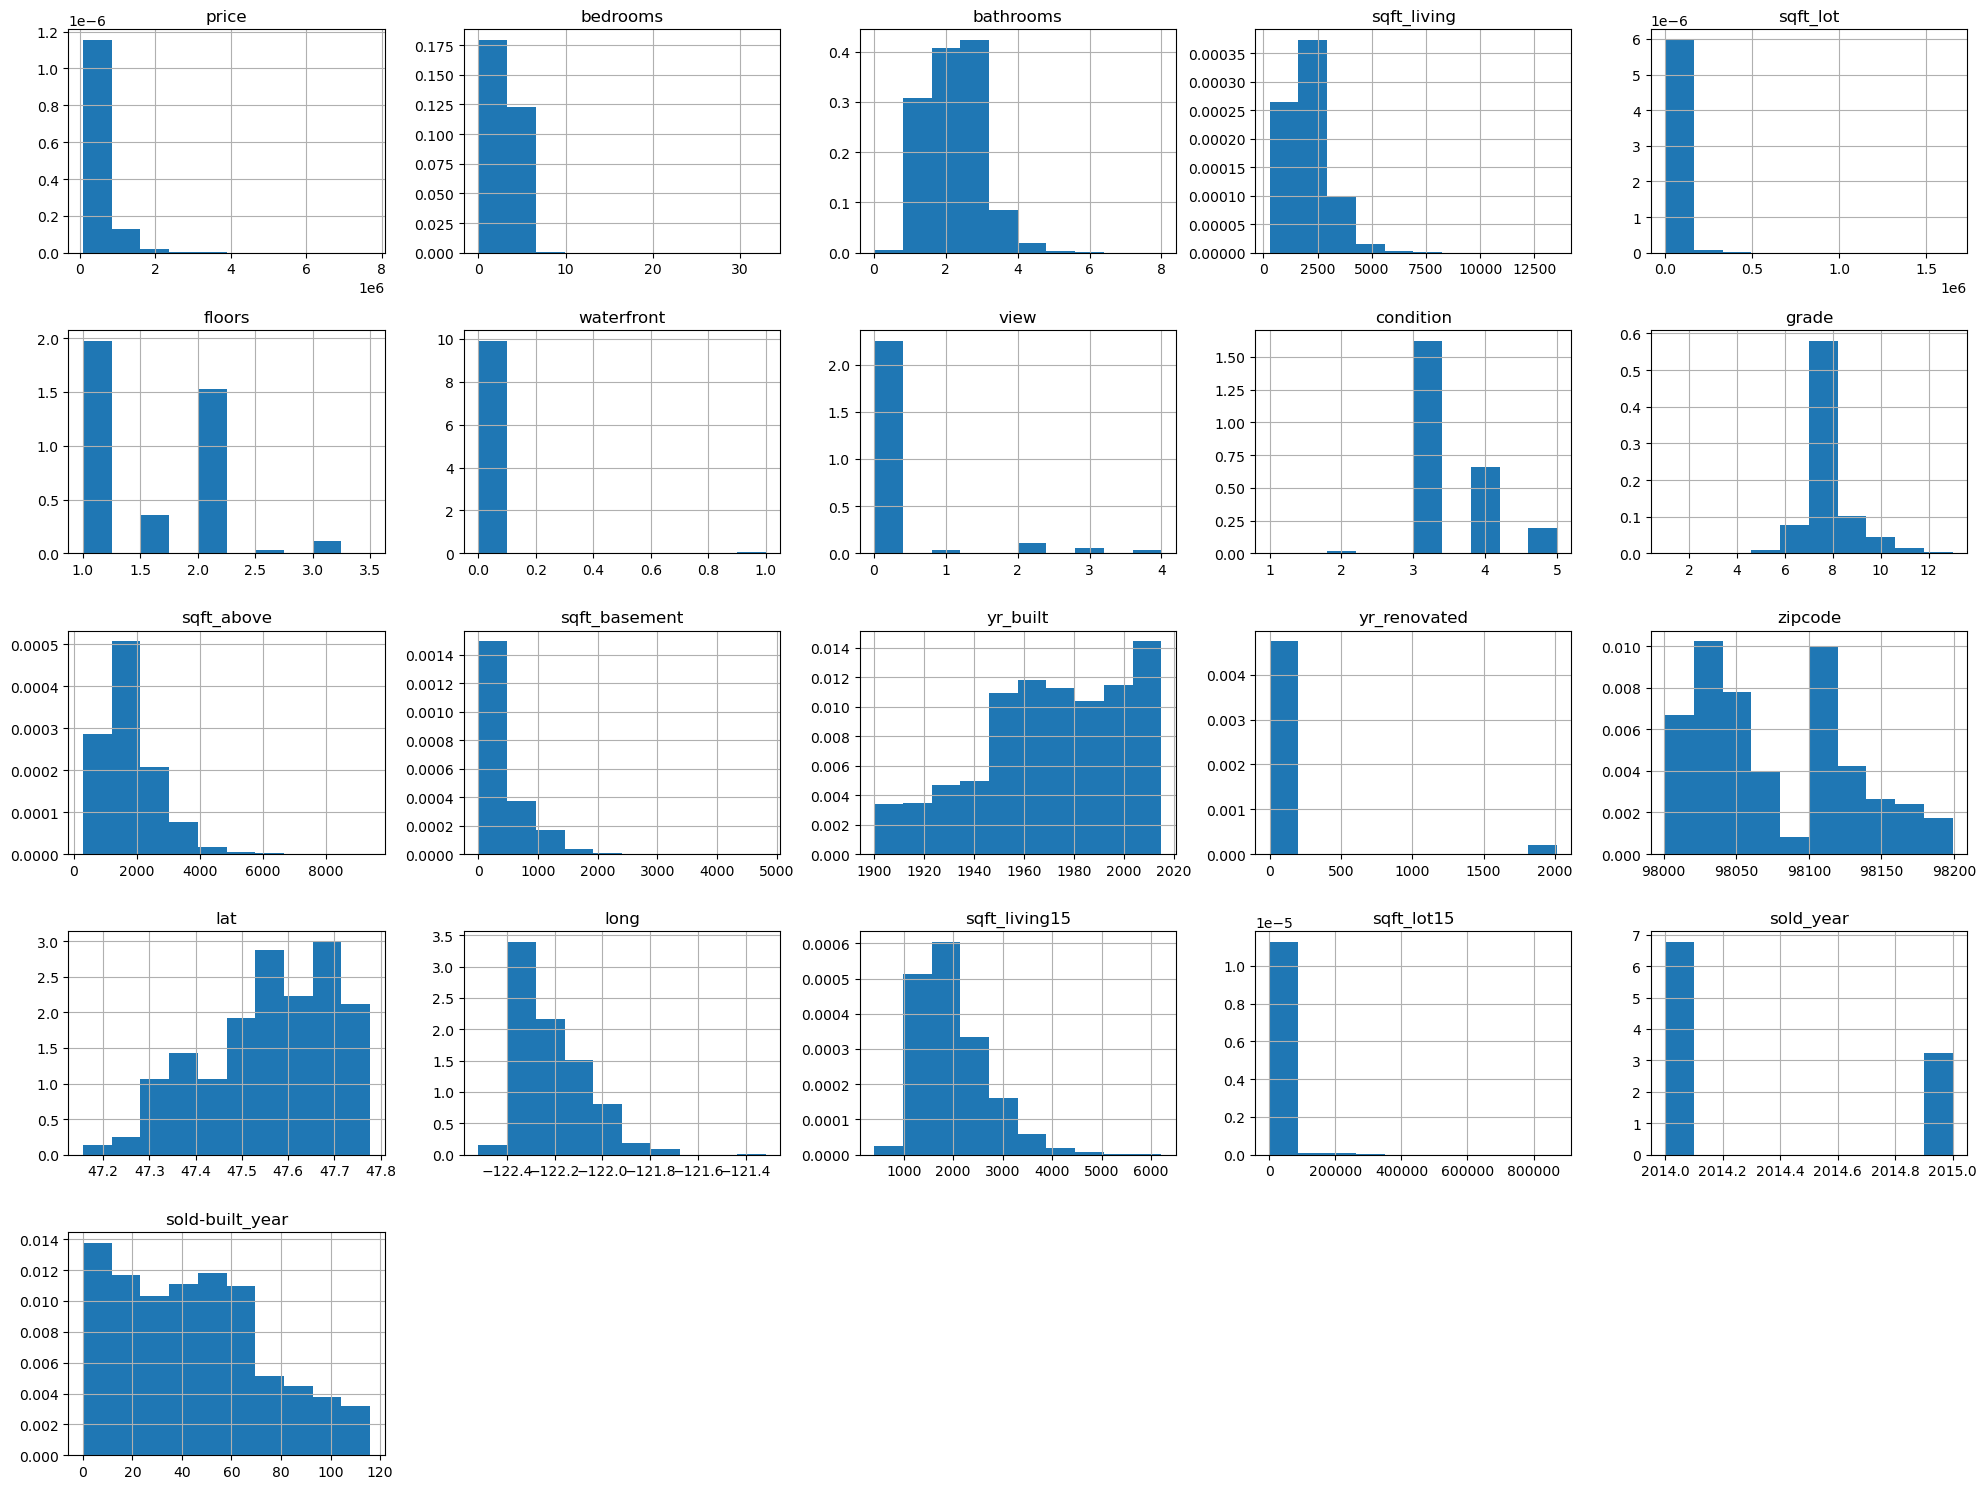

In [13]:
house_df.hist(figsize=(20,15), density=True)
plt.tight_layout()
plt.show()

#### 변수별 기술통계량

- 왜도, 첨도, 결측치 개수 포함

In [15]:
house_df_stats = house_df.describe()

# 왜도
skews = []
# 첨도
kurtosis = []
# 결측치
null = []

for col in house_df_stats.columns:
    skews.append(house_df[col].skew())
    kurtosis.append(house_df[col].kurtosis())
    null.append(house_df[col].isna().sum())

house_df_stats.loc['skewness'] = skews
house_df_stats.loc['kurtosis'] = kurtosis
house_df_stats.loc['n_null'] = null

house_df_stats

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sold_year,sold-built_year
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,...,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,2014.322954,44.317818
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,...,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.467616,29.375493
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,0.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,2014.000000,19.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,2014.000000,41.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,64.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,116.000000
skewness,4.024069e+00,1.974300,0.511108,1.471555,1.306002e+01,0.616177,11.385108,3.395750,1.032805,0.771103,...,1.577965,-0.469805,4.549493,0.405661,-0.485270,0.885053,1.108181,9.506743,0.757299,0.469162
kurtosis,3.458554e+01,49.063653,1.279902,5.243093,2.850778e+02,-0.484723,127.632494,10.893022,0.525764,1.190932,...,2.715574,-0.657408,18.701152,-0.853479,-0.676313,1.049501,1.597096,150.763110,-1.426630,-0.657983


#### 상관관계 히트맵

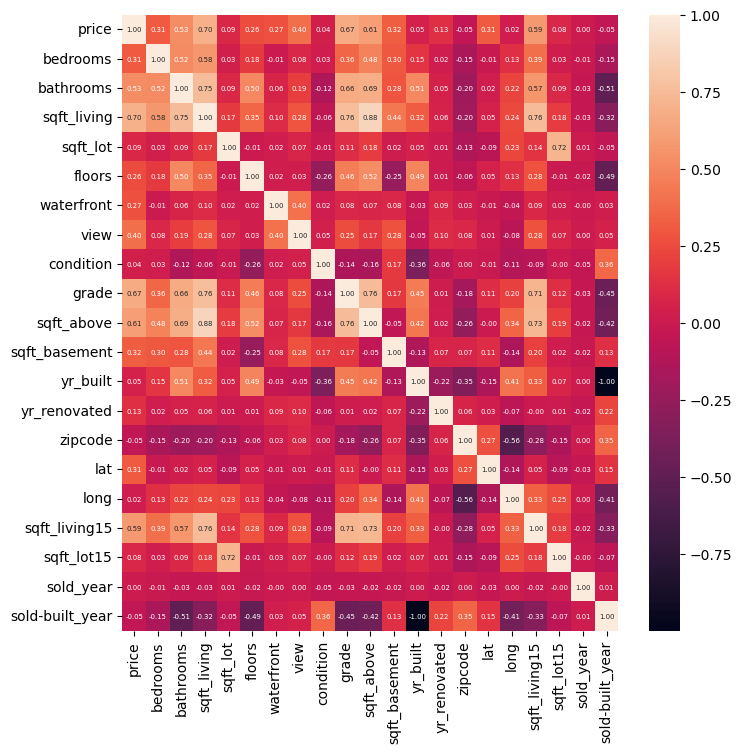

In [81]:
plt.figure(figsize=(8,8))
house_corr = house_df.corr()
sns.heatmap(house_corr, annot=True, fmt='.2f', annot_kws={'size':5})
plt.show()

#### 주택가격과 상관관계

- pearsonr: 상관관계의 계수를 알려주고, p-value는 그 계수가 유의미 한지 제공

In [78]:
from scipy import stats

coef_list = []
p_list = []
for col in house_df.columns:
    coef, p = stats.pearsonr(house_df.price, house_df[col])
    coef_list.append(np.round(coef, 4))
    p_list.append(p)

house_df_corr = pd.DataFrame({'pearsonr': coef_list, 'p_value': p_list}, 
             index=house_df.columns).sort_values('pearsonr', ascending=False)

#### 주요 피처와 주택가격과의 관계(산점도, regplot)

In [79]:
house_df_corr.index

Index(['price', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15',
       'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'lat', 'waterfront',
       'floors', 'yr_renovated', 'sqft_lot', 'sqft_lot15', 'yr_built',
       'condition', 'long', 'sold_year', 'zipcode', 'sold-built_year'],
      dtype='object')

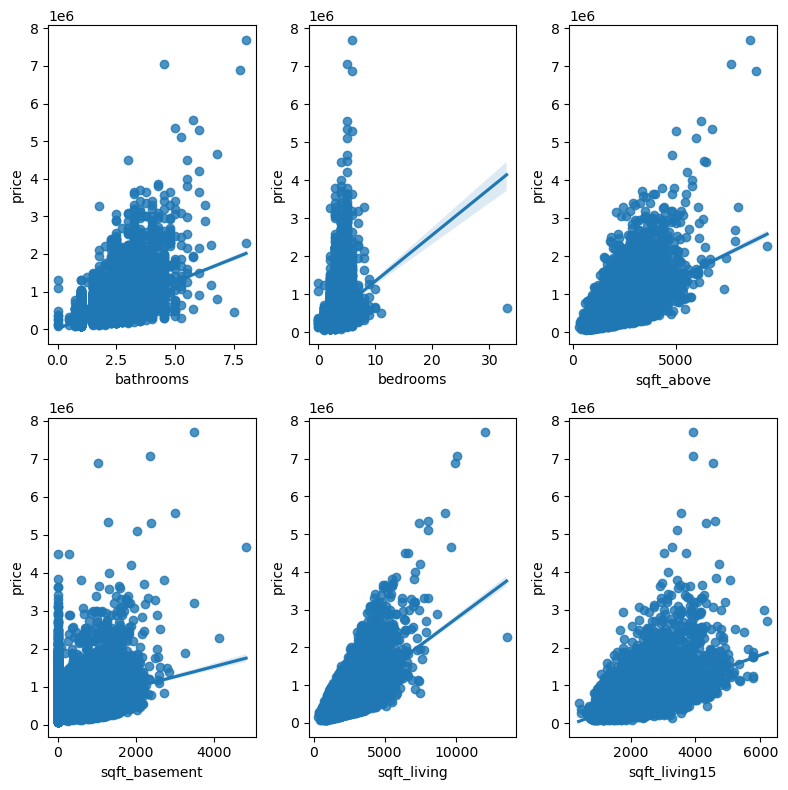

In [80]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=3)
ftr_names = house_df_corr.index[:9].difference(['price','grade','view'])

for i, ftr in enumerate(ftr_names):
    row, col = i//3, i%3
    sns.regplot(data=house_df, x=ftr, y='price', ax=ax[row][col])
plt.tight_layout()
plt.show()

#### 주택가격 예측에 영향이 작은 변수 삭제 

- price와 상관관계가 매우 약한(corr<0.2) 변수들
    - ```python
      ['yr_renovated', 'sqft_lot', 'sqft_lot15', 'yr_built', 'condition',
       'long', 'sold_year', 'zipcode','lat']
       ```

- 'sqft_living'과 상관관계가 강한 변수들
    - ```python
      ['sqft_above','sqft_living15']
       ```
- 'sold-built_years'를 도출한 변수들
    - ```python
      ['sold_year','yr_built']
       ```  

In [86]:
# price와 상관관계가 매우 약한(corr<0.2) 변수들
house_df_corr[house_df_corr['pearsonr'] < 0.2].index

Index(['yr_renovated', 'sqft_lot', 'sqft_lot15', 'yr_built', 'condition',
       'long', 'sold_year', 'zipcode', 'sold-built_year'],
      dtype='object')

##### 데이터 변환 함수 수정

In [95]:
def data_preprocessing(df):
    df_new = df.copy()
    df_new['sold_year'] = df_new.date.str[:4].astype('int64')
    df_new['sold-built_year'] = df_new['sold_year'] - df_new['yr_built'] + 1
    ftr_names = ['id','date','yr_renovated', 'sqft_lot', 'sqft_lot15', 'yr_built', 'condition',
                 'long', 'sold_year', 'zipcode', 'lat',
                 'sqft_above','sqft_living15','sold_year']
    df_new.drop(ftr_names,axis=1, inplace=True)
    return df_new

In [96]:
house_df2 = data_preprocessing(house)
house_df2.head(3)

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_basement,sold-built_year
0,221900.0,3,1.00,1180,1.0,0,0,7,0,60
1,538000.0,3,2.25,2570,2.0,0,0,7,400,64
2,180000.0,2,1.00,770,1.0,0,0,6,0,83


### 선형 회귀 모델 학습/예측/평가

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [100]:
x = house_df2.drop('price',axis=1)
y = house_df2.price

# 학습/테스트 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=156)

# 모델 객체 생성
lr= LinearRegression()

# 학습
lr.fit(x_train, y_train)

# 예측
y_pred = lr.predict(x_test)

# 성능평가
# MSE(평균 제곱 오차): 잔차를 제곱하여 평균 / MSE가 낮을수록 모델의 성능이 좋다 /오차의 제곱을 취하기 때문에, 큰 오차에 대해 더 큰 벌점을 부여
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

# MAE(평균 절대 오차): 잔차의 절대값을 평균 / MAE가 낮을수록 모델의 성능이 좋다
mae = mean_absolute_error(y_test, y_pred)

# 결정계수: 모델이 데이터의 분산을 얼마나 잘 설명하는지를 나타내는 지표
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}')

MSE: 44692031278.56, RMSE: 211404.90, MAE: 139043.72, R2: 0.642


- 모델이 데이터를 얼마나 잘 예측하는지를 수치적으로 나타냄
- MSE(평균 제곱 오차): 잔차를 제곱하여 평균 / MSE가 낮을수록 모델의 성능이 좋다 /오차의 제곱을 취하기 때문에, 큰 오차에 대해 더 큰 벌점을 부여
- MAE(평균 절대 오차): 잔차의 절대값을 평균 / MAE가 낮을수록 모델의 성능이 좋다
- RMSE: MSE를 제곱근한 것.
- ex) MAE를 이용해서 평균적으로 모델 예측이 실제 가격과 얼마나 차이나는지를 직관적으로 이해할 수 있다.

#### 회귀 모델의 절편, 회귀계수

- coef: 이 계수는 각 특성이 예측 변수에 미치는 영향의 크기와 방향을 나타냄.
    - ex) 집의 크기와 방의 수가 주택 가격 예측에 얼마나 영향을 미치는지를 나타내는 값
- intercept: 절편은 독립 변수(특성)가 모두 0일 때의 예측 변수의 값 / 즉, 모든 특성의 영향을 받지 않는 기본 값 / [ y = mx + b ] -> b
    - 그래프에서는 이 절편은 y축을 어디서 자르는지를 나타냄.

In [102]:
print(f'절편= {lr.intercept_:.4f}\n회귀계수: {lr.coef_}')

절편= -965452.9242
회귀계수: [-3.72524145e+04  5.19351338e+04  1.65905524e+02  2.14760639e+04
  5.42343913e+05  4.44717325e+04  1.25186558e+05  8.47468036e+00
  3.82375564e+03]


In [107]:
coefs = pd.DataFrame(data=lr.coef_, index=x.columns, columns=['coef'])
coefs.loc['intercept'] = lr.intercept_
coefs

,coef
bedrooms,-37252.414529
bathrooms,51935.133791
sqft_living,165.905524
floors,21476.063924
waterfront,542343.913429
view,44471.732492
grade,125186.557968
sqft_basement,8.474680
sold-built_year,3823.755644
intercept,-965452.924237


#### 회귀계수를 큰 값 순으로 정렬

In [108]:
coeff = coefs.sort_values('coef', ascending=False)
coeff

,coef
waterfront,542343.913429
grade,125186.557968
bathrooms,51935.133791
view,44471.732492
floors,21476.063924
sold-built_year,3823.755644
sqft_living,165.905524
sqft_basement,8.474680
bedrooms,-37252.414529
intercept,-965452.924237


#### 회귀계수 시각화

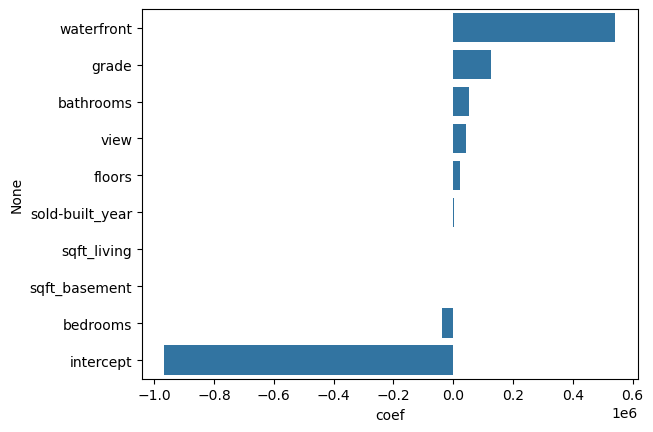

In [109]:
sns.barplot(data=coeff, x=coeff.coef, y=coeff.index)
plt.show()

#### 회귀계수 출력 및 시각화 함수 작성

In [110]:
def reg_coef_plot(model, ftr_names):
    coef = pd.Series(data=np.round(model.coef_,1), index=ftr_names).sort_values(ascending=False)
    print(f'회귀계수: {coef}')
    sns.barplot(x=coef, y=coef.index)
    plt.show()

회귀계수: waterfront         542343.9
grade              125186.6
bathrooms           51935.1
view                44471.7
floors              21476.1
sold-built_year      3823.8
sqft_living           165.9
sqft_basement           8.5
bedrooms           -37252.4
dtype: float64


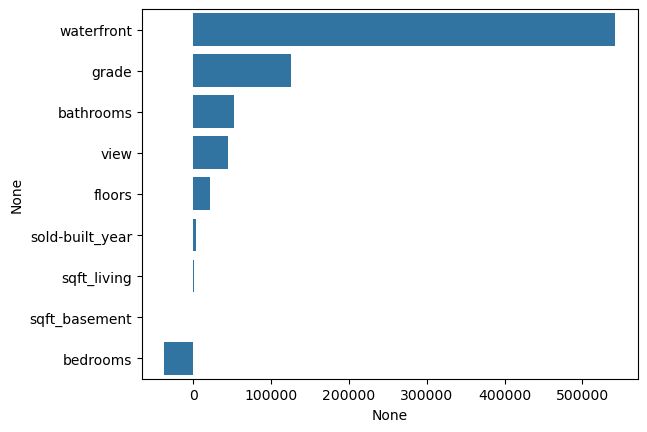

In [112]:
reg_coef_plot(lr, x.columns)

- LinearRegression.score() 메서드 => 결정계수 

In [151]:
# 학습데이터 세트와 테스트데이터 세트에 대한 결정계수 확인
print(f'학습데이터 세트의 R_square: {lr.score(x_train, y_train):.2f}')
print(f'테스트데이터 세트의 R_square: {lr.score(x_test, y_test):.2f}')

학습데이터 세트의 R_square: 0.65
테스트데이터 세트의 R_square: 0.64


#### 실제값과 예측값과의 차이

In [164]:
def get_residual(y_test, y_pred, top_n=10):
    residual = y_test - y_pred
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                       'residual': residual, 'abs(resid)':np.abs(residual)})
    top = df.sort_values('abs(resid)',ascending=False)[:top_n]
    return top

In [165]:
get_residual(y_test, y_pred)

,y_test,y_pred,residual,abs(resid)
3914,7062500.0,3.105758e+06,3.956742e+06,3.956742e+06
18482,3650000.0,1.508862e+06,2.141138e+06,2.141138e+06
19148,3635000.0,1.654146e+06,1.980854e+06,1.980854e+06
11535,3200000.0,1.520077e+06,1.679923e+06,1.679923e+06
21530,3000000.0,1.342465e+06,1.657535e+06,1.657535e+06
15255,3640900.0,2.091479e+06,1.549421e+06,1.549421e+06
11975,3000000.0,1.574528e+06,1.425472e+06,1.425472e+06
14052,2750000.0,1.325002e+06,1.424998e+06,1.424998e+06
2899,3000000.0,1.590414e+06,1.409586e+06,1.409586e+06
269,2900000.0,1.522909e+06,1.377091e+06,1.377091e+06


### 교차 검증으로 MSE와 RMSE 측정

cross_val_score() 이용

In [173]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

neg_mse = cross_val_score(lr, x, y, cv= 5, scoring='neg_mean_squared_error')
rmse = np.sqrt(neg_mse * (-1))
avg_rmse = np.mean(rmse)

print(f'MSE: {np.round(neg_mse*(-1),2)}')
print(f'RMSE: {np.round(rmse, 2)}')
print(f'평균 RMSE: {avg_rmse:.2f}')

MSE: [5.24325442e+10 4.93197221e+10 4.22322999e+10 4.40322894e+10
 5.03632995e+10]
RMSE: [228981.54 222080.44 205504.99 209838.72 224417.69]
평균 RMSE: 218164.68


-------

### 주택가격 price를 로그변환하여 회귀분석 진행 

#### 주택가격 price 분포

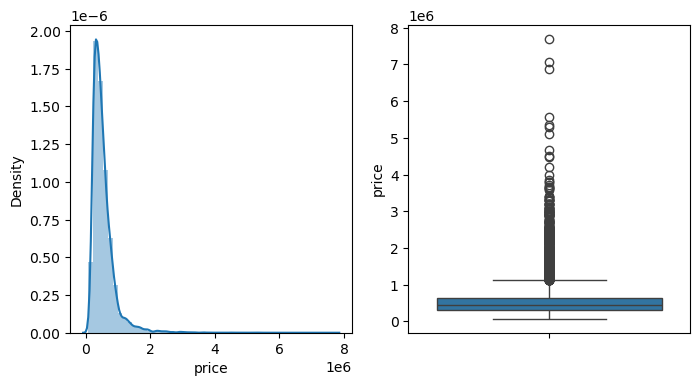

In [176]:
fig ,ax = plt.subplots(figsize=(8,4), ncols=2)
sns.distplot(house_df2.price, ax=ax[0])
sns.boxplot(house_df2.price, ax=ax[1])
plt.show()

#### 로그변환된 price 분포

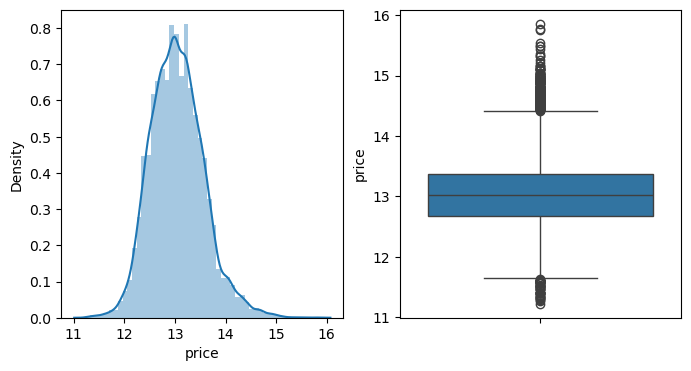

In [177]:
fig ,ax = plt.subplots(figsize=(8,4), ncols=2)
sns.distplot(np.log1p(house_df2.price), ax=ax[0])
sns.boxplot(np.log1p(house_df2.price), ax=ax[1])
plt.show()

#### 모델 성능 평가 RMSLE(Root Mean Square Log Error)를 위한 함수 작성

- 오류 값의 로그에 대한 RMSE

In [178]:
from sklearn.metrics import mean_squared_log_error

-> mean_squared_log_error() 함수를 사용하는 경우 데이터 값의 크기에 따라 오버플로나 언더플로가 발생하기 쉬워,
log1p()를 적용한 함수를 정의

In [204]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean((log_y - log_pred)**2))
    return rmsle

#### RMSE 함수작성

In [188]:
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

#### 회귀모델 성능 평가를 위한 함수 작성

- MSE, RMSE, RMSLE, MAE, R2 계산

In [224]:
def eval_regr_scores(y, pred, is_log=False):
    mse_ = mean_squared_error(y, pred)
    rmse_ = rmse(y, pred)
    rmsle_ = rmsle(y, pred)
    mae_ = mean_absolute_error(y, pred)
    r2_ = r2_score(y, pred)

    print(f'R_square: {r2_:.3f}')
    print(f'RMSE: {rmse_:.2f}')
    if is_log:
        print(f'RMSLE: {rmsle_:.2f}')
    print(f'MSE: {mse_:.2f}, MAE: {mae_:.2f}')

#### 로그변환된 주택가격 회귀모델 학습 및 평가

In [221]:
x = house_df2.drop('price', axis=1)
log_y = np.log1p(house_df2.price)

# 학습/테스트 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x,log_y, test_size=0.2, random_state=156)

# 모델 객체 생성
lr_log= LinearRegression()

# 학습
lr_log.fit(x_train, y_train)

# 예측
y_pred = lr_log.predict(x_test)

# 성능평가 / log1p를 했기때문에 -1를 해주면서 로그를 없앤 원래 데이터 값으로 만들기 -> expm1()
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
eval_regr_scores(y_test_exp, y_pred_exp, is_log=True)

R_square: 0.667
RMSE: 203734.58
RMSLE: 0.32
MSE: 41507778947.79, MAE: 132491.13


#### 실제값과 예측값과의 차이

In [220]:
resid_ = get_residual(y_test_exp, y_pred_exp)
resid_

,y_test,y_pred,residual,abs(resid)
4811,2479000.0,5.167299e+06,-2.688299e+06,2.688299e+06
18482,3650000.0,1.973367e+06,1.676633e+06,1.676633e+06
21530,3000000.0,1.344224e+06,1.655776e+06,1.655776e+06
11535,3200000.0,1.724015e+06,1.475985e+06,1.475985e+06
14052,2750000.0,1.367976e+06,1.382024e+06,1.382024e+06
19148,3635000.0,2.256102e+06,1.378898e+06,1.378898e+06
14139,2110000.0,7.629951e+05,1.347005e+06,1.347005e+06
11278,2100000.0,8.026703e+05,1.297330e+06,1.297330e+06
13020,2300000.0,1.027266e+06,1.272734e+06,1.272734e+06
19484,2395000.0,1.129778e+06,1.265222e+06,1.265222e+06


In [219]:
resid_log = get_residual(y_test, y_pred)
resid_log

,y_test,y_pred,residual,abs(resid)
18685,13.866205,12.620855,1.245349,1.245349
411,13.156832,11.915982,1.240851,1.240851
18988,11.849405,12.999756,-1.150351,1.150351
12551,11.407576,12.554303,-1.146727,1.146727
3767,11.338584,12.458744,-1.120160,1.120160
12208,11.652696,12.770736,-1.118040,1.118040
17930,14.115616,13.036450,1.079166,1.079166
15134,12.345839,13.391606,-1.045767,1.045767
8387,13.829661,12.798051,1.031610,1.031610
14139,14.562199,13.545008,1.017191,1.017191


#### 회귀계수 

회귀계수: waterfront         0.3
grade              0.2
bathrooms          0.1
floors             0.1
bedrooms          -0.0
sqft_living        0.0
view               0.0
sqft_basement      0.0
sold-built_year    0.0
dtype: float64


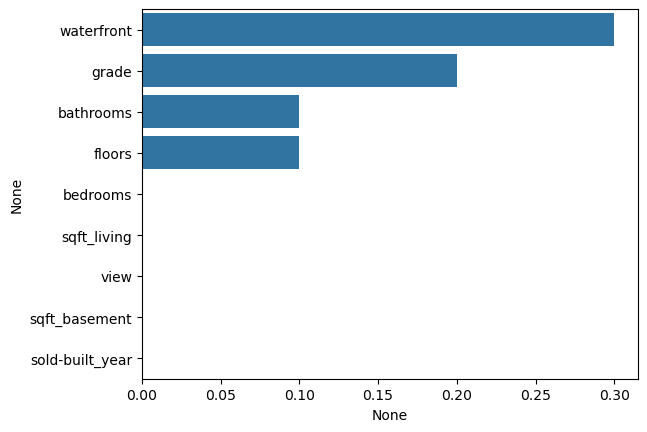

In [222]:
reg_coef_plot(lr_log, x.columns)

#### 회귀모델 학습 및 평가 수치 반환 함수 작성

In [226]:
def get_modeling_predict(model,x,y, is_log=False):
    # 학습/테스트 데이터 분할
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=156)
    # 학습
    model.fit(x_train, y_train)
    # 예측
    y_pred = model.predict(x_test)
    # 평가결과 출력
    if is_log:
        y_test, y_pred = np.expm1(y_test), np.expm1(y_pred)
        text = 'log변환'
    else:
        text = ''
    print(f'## {model.__class__.__name__} {text} ##')
    eval_regr_scores(y_test, y_pred, is_log=is_log)

In [231]:
x = house_df2.drop('price', axis=1)
y = house_df2.price
log_y = np.log1p(y)

# 모델 객체 생성
lr_log= LinearRegression()

# 원데이터로 회귀분석
print('--- 원데이터로 회귀분석 ---')
get_modeling_predict(lr_log, x, y)
print()
# 종속변수를 로그변환한 데이터로 회귀분석
print('--- 종속변수를 로그변환한 데이터로 회귀분석 ---')
get_modeling_predict(lr_log, x, log_y, is_log=True)

--- 원데이터로 회귀분석 ---
## LinearRegression  ##
R_square: 0.642
RMSE: 211404.90
MSE: 44692031278.56, MAE: 139043.72

--- 종속변수를 로그변환한 데이터로 회귀분석 ---
## LinearRegression log변환 ##
R_square: 0.667
RMSE: 203734.58
RMSLE: 0.32
MSE: 41507778947.79, MAE: 132491.13


------

### 범주형 변수 원한인코딩 후 회귀분석 진행

In [232]:
house_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21613 non-null  float64
 1   bedrooms         21613 non-null  int64  
 2   bathrooms        21613 non-null  float64
 3   sqft_living      21613 non-null  int64  
 4   floors           21613 non-null  float64
 5   waterfront       21613 non-null  int64  
 6   view             21613 non-null  int64  
 7   grade            21613 non-null  int64  
 8   sqft_basement    21613 non-null  int64  
 9   sold-built_year  21613 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 1.6 MB


In [235]:
for ftr in ['waterfront','view']:
    freq = house_df2[ftr].value_counts()
    print(f'Freq of {ftr}:\n{freq.sort_index()}')
    print('----------------------------------')

Freq of waterfront:
waterfront
0    21450
1      163
Name: count, dtype: int64
----------------------------------
Freq of view:
view
0    19489
1      332
2      963
3      510
4      319
Name: count, dtype: int64
----------------------------------


In [242]:
house_df2.groupby('waterfront').describe().T.unstack(level=1)

waterfront             0                                                   \
                   count           mean            std      min       25%   
price            21450.0  531563.599814  341599.589656  75000.0  320000.0   
bedrooms         21450.0       3.371375       0.928856      0.0       3.0   
bathrooms        21450.0       2.110478       0.765648      0.0       1.5   
sqft_living      21450.0    2071.587972     906.257233    290.0    1420.0   
floors           21450.0       1.493193       0.539740      1.0       1.0   
view             21450.0       0.207459       0.702686      0.0       0.0   
grade            21450.0       7.648392       1.165861      1.0       7.0   
sqft_basement    21450.0     288.400000     437.413797      0.0       0.0   
sold-built_year  21450.0      44.251002      29.376950      0.0      19.0   

waterfront                                           1                \
                       50%       75%        max  count          mean   
price            450000.00  639897.0  7700000.0  163.0  1.661876e+06   
bedrooms              3.00       4.0       33.0  163.0  3.300613e+00   
bathrooms             2.25       2.5        8.0  163.0  2.677914e+00   
sqft_living        1910.00    2540.0    13540.0  163.0  3.173687e+03   
floors                1.50       2.0        3.5  163.0  1.641104e+00   
view                  0.00       0.0        4.0  163.0  3.766871e+00   
grade                 7.00       8.0       13.0  163.0  8.773006e+00   
sqft_basement         0.00     560.0     4130.0  163.0  7.006442e+02   
sold-built_year      40.00      64.0      116.0  163.0  5.311043e+01   

waterfront                                                                 \
                          std        min       25%        50%         75%   
price            1.120372e+06  285000.00  760000.0  1400000.0  2215000.00   
bedrooms         1.078035e+00       1.00       3.0        3.0        4.00   
bathrooms        1.092456e+00       0.75       2.0        2.5        3.25   
sqft_living      1.606025e+03     440.00    2060.0     2850.0     3905.00   
floors           5.541906e-01       1.00       1.0        2.0        2.00   
view             5.618593e-01       1.00       4.0        4.0        4.00   
grade            1.761385e+00       5.00       8.0        9.0       10.00   
sqft_basement    7.929200e+02       0.00       0.0      500.0     1245.00   
sold-built_year  2.790217e+01       1.00      29.0       55.0       74.50   

waterfront                   
                        max  
price            7062500.00  
bedrooms               6.00  
bathrooms              6.75  
sqft_living        10040.00  
floors                 3.00  
view                   4.00  
grade                 12.00  
sqft_basement       4820.00  
sold-built_year      112.00

In [243]:
house_df2.groupby('view').mean().T

view,0,1,2,3,4
price,496564.192108,812280.837349,792400.887850,971965.274510,1.463711e+06
bedrooms,3.346247,3.536145,3.564901,3.672549,3.633229e+00
bathrooms,2.069719,2.349398,2.425753,2.671078,2.793887e+00
sqft_living,1997.761660,2568.960843,2655.257529,3018.564706,3.351473e+03
floors,1.491123,1.396084,1.518692,1.564706,1.605016e+00
waterfront,0.000000,0.003012,0.008307,0.037255,4.231975e-01
grade,7.564780,8.117470,8.320872,8.733333,9.078370e+00
sqft_basement,251.285392,635.786145,568.306334,741.915686,8.349436e+02
sold-built_year,43.708092,52.343373,50.401869,47.872549,4.916614e+01


#### 범주형 변수 원핫인코딩

- waterfront, view

In [250]:
# 원핫인코딩 -> pd.get_dummies
x_ohe = pd.get_dummies(x, columns=['waterfront','view'], dtype='int')
x_ohe.head(3)

,bedrooms,bathrooms,sqft_living,floors,grade,sqft_basement,sold-built_year,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4
0,3,1.00,1180,1.0,7,0,60,1,0,1,0,0,0,0
1,3,2.25,2570,2.0,7,400,64,1,0,1,0,0,0,0
2,2,1.00,770,1.0,6,0,83,1,0,1,0,0,0,0


#### 로그변환, 원핫인코딩한 데이터로 회귀모델 예측

In [249]:
# 종속변수를 로그변환 후 x:원핫인코딩 적용
print('--- 종속변수를 로그변환 후 x:원핫인코딩 적용 ---')
get_modeling_predict(lr_log, x_ohe, log_y, is_log=True)

--- 종속변수를 로그변환 후 x:원핫인코딩 적용 ---
## LinearRegression log변환 ##
R_square: 0.671
RMSE: 202663.77
RMSLE: 0.32
MSE: 41072604129.69, MAE: 132363.66


```python
--- 원데이터로 회귀분석 ---
## LinearRegression  ##
R_square: 0.642
RMSE: 211404.90
MSE: 44692031278.56, MAE: 139043.72

--- 종속변수를 로그변환한 데이터로 회귀분석 ---
## LinearRegression log변환 ##
R_square: 0.667
RMSE: 203734.58
RMSLE: 0.32
MSE: 41507778947.79, MAE

--- 종속변수를 로그변환 후 x:원핫인코딩 적용 ---
## LinearRegression log변환 ##
R_square: 0.671
RMSE: 202663.77
RMSLE: 0.32
MSE: 41072604129.69, MAE: 1323
```63.66: 132491.13

#### 회귀계수 

--- price log변환 + 원핫인코딩 적용한 경우 회귀계수 ---
회귀계수: grade              0.2
bathrooms          0.1
floors             0.1
waterfront_1       0.1
view_1             0.1
view_4             0.1
bedrooms          -0.0
sqft_living        0.0
sqft_basement      0.0
sold-built_year    0.0
view_2            -0.0
view_3            -0.0
waterfront_0      -0.1
view_0            -0.1
dtype: float64


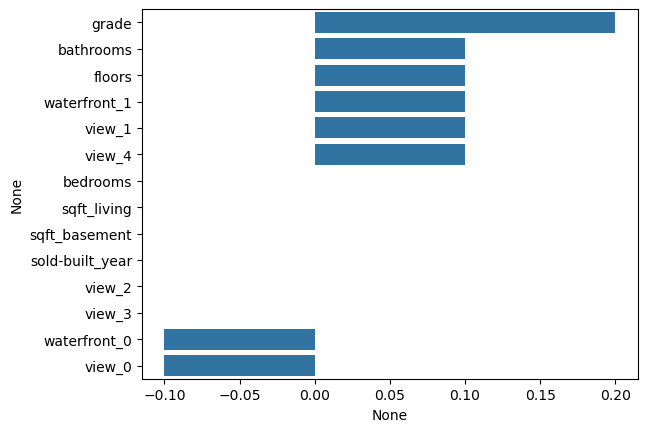

In [252]:
print('--- price log변환 + 원핫인코딩 적용한 경우 회귀계수 ---')
reg_coef_plot(lr_log, x_ohe.columns)

-------------------------------------------------

**정리**
- 모델이 데이터를 얼마나 잘 예측하는지를 수치적으로 나타냄
- MSE(평균 제곱 오차): 잔차를 제곱하여 평균 / MSE가 낮을수록 모델의 성능이 좋다 /오차의 제곱을 취하기 때문에, 큰 오차에 대해 더 큰 벌점을 부여
- MAE(평균 절대 오차): 잔차의 절대값을 평균 / MAE가 낮을수록 모델의 성능이 좋다
- RMSE: MSE를 제곱근한 것.
- ex) MAE를 이용해서 평균적으로 모델 예측이 실제 가격과 얼마나 차이나는지를 직관적으로 이해할 수 있다.

- coef: 이 계수는 각 특성이 예측 변수에 미치는 영향의 크기와 방향을 나타냄.
    - ex) 집의 크기와 방의 수가 주택 가격 예측에 얼마나 영향을 미치는지를 나타내는 값
- intercept: 절편은 독립 변수(특성)가 모두 0일 때의 예측 변수의 값 / 즉, 모든 특성의 영향을 받지 않는 기본 값 / [ y = mx + b ] -> b
    - 그래프에서는 이 절편은 y축을 어디서 자르는지를 나타냄.르는지를 나타냄.